In [32]:
import matplotlib.pyplot as plt
import openfermion as of
from Hubbard_Model_nnn import *
import jax.numpy as jnp
from itertools import product
from jax import config
from numpy.polynomial.chebyshev import Chebyshev
from scipy.io import loadmat
import scipy.sparse as sp
import glob
config.update("jax_enable_x64", True)

# Set parameters.

In [12]:
# Parameters.
x_dimension = 2
y_dimension = 2
n_up = 2
n_down = 2

n_site = x_dimension * y_dimension

U = 1
t = 1.0
t_prime = 0.3
mu = 0.0

## Construct the reduced Hamiltonian.

In [13]:
def reduced_hubbard_model(U, indices):
    hopping_terms = fermi_hubbard_nnn(x_dimension, y_dimension, tunneling=t, nnn_tunneling=t_prime, coulomb=U, chemical_potential=mu, periodic=True)
    hopping_terms = of.get_sparse_operator(hopping_terms)
    H_hubbard = hopping_terms[jnp.ix_(indices, indices)].toarray()

    return H_hubbard

In [14]:
valid_indices = []
for bits in product('01', repeat= 2 * x_dimension * y_dimension):

    spin_up_indices = bits[::2]
    spin_down_indices = bits[1::2]

    if spin_up_indices.count('1') == n_up and spin_down_indices.count('1') == n_down:
        binary_str = ''.join(bits)
        valid_indices.append(int(binary_str, 2))

reduced_H_indices = jnp.array(valid_indices)

H_reduced = reduced_hubbard_model(U=U, indices=reduced_H_indices)
reduced_dim = len(H_reduced)
print('reduced_dim =', reduced_dim)

H_reduced_eigvals, H_reduced_eigvecs = jnp.linalg.eigh(H_reduced)
print(f"Eigenvalues:", jnp.round(H_reduced_eigvals[:8], 3))

reduced_dim = 36
Eigenvalues: [-7.298 -7.271 -6.825 -6.769 -5.677 -5.677 -5.174 -5.174]


In [15]:
U_sweep_ED = jnp.linspace(0, U, 80)

H_eigvals_sweep = []

for UU in U_sweep_ED:
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    eigvals = jnp.linalg.eigvalsh(H)
    H_eigvals_sweep.append(eigvals)

H_eigvals_sweep = jnp.array(H_eigvals_sweep).T

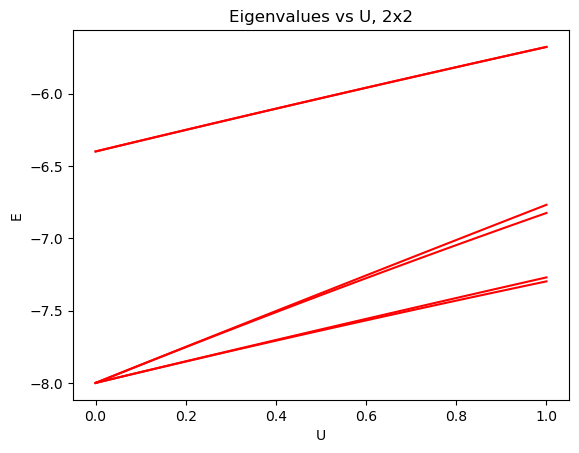

In [16]:
for band in range(6):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')


plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

# plt.legend()
plt.show()

# Schur complement

In [17]:
def find_degeneracies(E0, tol=1E-10):

    sorted_indices = jnp.argsort(E0)
    sorted_E0 = jnp.array(E0)[sorted_indices]
    
    degeneracy_counts = []

    current_degeneracy = 1

    for i in range(1, len(sorted_E0)):
        if jnp.abs(sorted_E0[i] - sorted_E0[i - 1]) < tol:

            current_degeneracy += 1
        else:

            degeneracy_counts.append(current_degeneracy)
            current_degeneracy = 1

    degeneracy_counts.append(current_degeneracy)
    
    return degeneracy_counts

def degenerate_states(Hi, H0_eigvecs, degeneracy_counts):

    start_index = 0
    for i, count in enumerate(degeneracy_counts):
        
        P = H0_eigvecs[:, start_index:start_index+count]
        P_T = jnp.conj(P.T)
        Hi_proj = P_T @ Hi @ P

        Hi_eigvals, Hi_eigvecs = jnp.linalg.eigh(Hi_proj)
        Hi_eigvecs = P @ Hi_eigvecs
        
        if i == 0:
            print("Eigenvalues of first Hi: \n", Hi_eigvals)
        
        H0_eigvecs = H0_eigvecs.at[:, start_index:start_index + count].set(Hi_eigvecs)
        start_index += count

    return H0_eigvecs

In [18]:
H0 =  reduced_hubbard_model(U=0, indices=reduced_H_indices)

H0_eigvals, H0_eigvecs = jnp.linalg.eigh(H0)
print("Eigenvalues of H0: \n", jnp.round(H0_eigvals[:8], 3))

Hi = reduced_hubbard_model(U=1, indices=reduced_H_indices) - H0

Eigenvalues of H0: 
 [-8.  -8.  -8.  -8.  -6.4 -6.4 -6.4 -6.4]


In [19]:
degeneracy_counts = find_degeneracies(H0_eigvals[:], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
k = sum(degeneracy_counts[:1])

degeneracy_counts = find_degeneracies(H0_eigvals[:k], tol=1E-10)
print("Number of degerate Eigenvalues:\n", degeneracy_counts)
H0_eigvecs_updated = degenerate_states(Hi, H0_eigvecs[:, :k], degeneracy_counts)
H0_eigvals_updated = H0_eigvals[:k]

degeneracy_idx = [0, k-1]
degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1

Number of degerate Eigenvalues:
 [4, 4, 1, 4, 10, 4, 1, 4, 4]
Number of degerate Eigenvalues:
 [4]
Eigenvalues of first Hi: 
 [0.75 0.75 1.25 1.25]


In [20]:
def Schur_complement(H, E, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    # C = O @ H @ O
    # print(jnp.linalg.det(C-H))
    M_inv = jnp.linalg.inv(M)

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [21]:
def Schur_complement_qsp(H, E, init_eigvecs, degeneracy_idx, dim, poly, kappa):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    Hij = jnp.conj(degeneracy_eigvecs.T) @ H @ degeneracy_eigvecs

    alpha = 1
    gamma = 1E-10
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    M = alpha * O + Q @ (E * jnp.eye(dim) - H) @ Q + gamma * 1j * jnp.eye(dim)

    N = jnp.linalg.norm(M)
    M = M / N
    
    M_eigvals, M_eigvecs = jnp.linalg.eigh(M)
    M_eigvals_inv = jnp.diag(poly(M_eigvals))
    M_inv = M_eigvecs @ M_eigvals_inv @ jnp.conj(M_eigvecs.T) * 2 * kappa / N

    Rij = jnp.conj(degeneracy_eigvecs.T) @ H @ Q @ M_inv @ Q @ H @ degeneracy_eigvecs

    return jnp.real(Hij + Rij - E * jnp.eye(degeneracy_dim))

In [129]:
def QHQ_spectrum(H, init_eigvecs, degeneracy_idx, dim):
    degeneracy_dim = degeneracy_idx[1] - degeneracy_idx[0] + 1
    degeneracy_eigvecs = init_eigvecs[:, degeneracy_idx[0]:degeneracy_idx[1] + 1]
    
    O = jnp.zeros((dim, dim))
    for d in range(degeneracy_dim):
        O += jnp.outer(degeneracy_eigvecs[:, d], jnp.conj(degeneracy_eigvecs[:, d]))
    Q = jnp.eye(dim) - O
    QHQ = Q @ H @ Q

    spectrum = jnp.linalg.eigh(QHQ)

    return spectrum

In [130]:
QHQ_eigvals, QHQ_eigvecs = QHQ_spectrum(H=H_reduced, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim)

## Eigenbranches (error $ = 10^{-3}$)

In [131]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [132]:
Xlim = [H_reduced_eigvals[0] - 0.1, H_reduced_eigvals[10] + 0.1]
N_plot = 500
Energy = jnp.linspace(Xlim[0], Xlim[1], N_plot)

In [133]:
Eigenbranches = []
for En in Energy:
    Schur = Schur_complement_qsp(H=H_reduced, E=En, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa)
    sub_eigvals = jnp.linalg.eigvalsh(Schur)
    Eigenbranches.append(sub_eigvals)
Eigenbranches = jnp.array(Eigenbranches).T

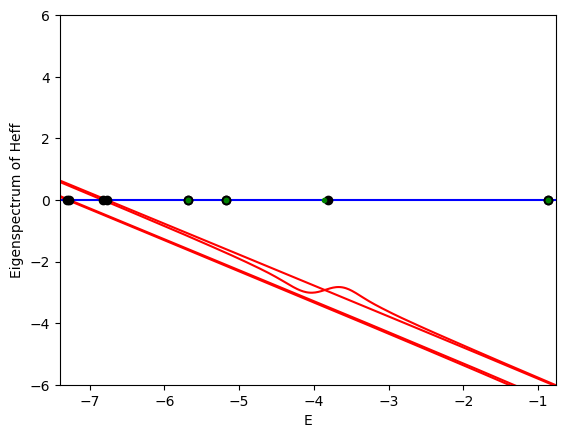

In [134]:
plt.xlabel('E')
plt.ylabel('Eigenspectrum of Heff')
plt.xlim(Xlim[0], Xlim[1])
# plt.xlim(4, 7)
plt.ylim(-6, 6)

for Eigenbranch in Eigenbranches:
    plt.plot(Energy, Eigenbranch, 'red')

plt.axhline(y=0, color='blue')

plt.plot(H_reduced_eigvals, jnp.zeros_like(H_reduced_eigvals), 'o', color='black')
plt.plot(QHQ_eigvals, jnp.zeros_like(QHQ_eigvals), 'o', color='green', markersize=3)

plt.show()

# Binary search 
### ($\Delta U = 0.1$)

## error $ = 10^{-3}$

In [22]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [23]:
U_sweep = jnp.linspace(0, U, 11)

In [27]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 6 iterations.
-7.9260968004490255
Converged in 6 iterations.
-7.925781929217559
Converged in 6 iterations.
-7.87666462648734
Converged in 6 iterations.
-7.876171570867179
solve: 2
Converged in 6 iterations.
-7.852632726295243
Converged in 6 iterations.
-7.851376480157423
Converged in 6 iterations.
-7.753769807712648
Converged in 6 iterations.
-7.751761671084882
solve: 3
Converged in 6 iterations.
-7.780157339781477
Converged in 6 iterations.
-7.777362200428829
Converged in 6 iterations.
-7.632320157890211
Converged in 6 iterations.
-7.627723676226255
solve: 4
Converged in 6 iterations.
-7.7086194029166855
Converged in 6 iterations.
-7.703745597370181
Converged in 6 iterations.
-7.512356312424039
Converged in 6 iterations.
-7.504052010900018
solve: 5
Converged in 6 iterations.
-7.637957805148993
Converged in 6 iterations.
-7.630533249837394
Converged in 6 iterations.
-7.393909446031781
Converged in 6 iterations.
-7.380732512867749
solve: 6
Converged in 6 iterations

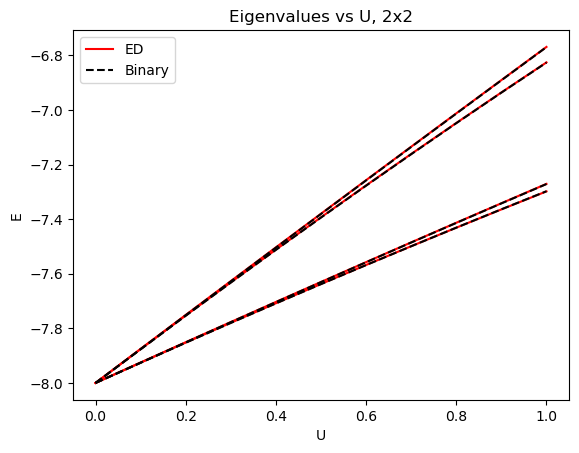

In [29]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [30]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

0.000510187113738958
-0.0005769316148862558
-0.0005295520481727323
-0.0006474252591113228


## error $ = 10^{-6}$

In [71]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [72]:
U_sweep = jnp.linspace(0, U, 11)

In [73]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 16 iterations.
-7.9255054591463985
Converged in 16 iterations.
-7.925196865592957
Converged in 16 iterations.
-7.875691400254235
Converged in 16 iterations.
-7.875195287437965
solve: 2
Converged in 16 iterations.
-7.852008516654967
Converged in 16 iterations.
-7.85078965764954
Converged in 16 iterations.
-7.752790321190632
Converged in 16 iterations.
-7.75077437894606
solve: 3
Converged in 16 iterations.
-7.779492643331886
Converged in 16 iterations.
-7.776784799561139
Converged in 16 iterations.
-7.6313393303341375
Converged in 16 iterations.
-7.626732401030242
solve: 4
Converged in 16 iterations.
-7.707941091104058
Converged in 16 iterations.
-7.703188147101574
Converged in 16 iterations.
-7.511380198960925
Converged in 16 iterations.
-7.503063587730319
solve: 5
Converged in 16 iterations.
-7.637337269212704
Converged in 16 iterations.
-7.6300056055305445
Converged in 16 iterations.
-7.392954589019356
Converged in 16 iterations.
-7.379762209528154
solve: 6
Conve

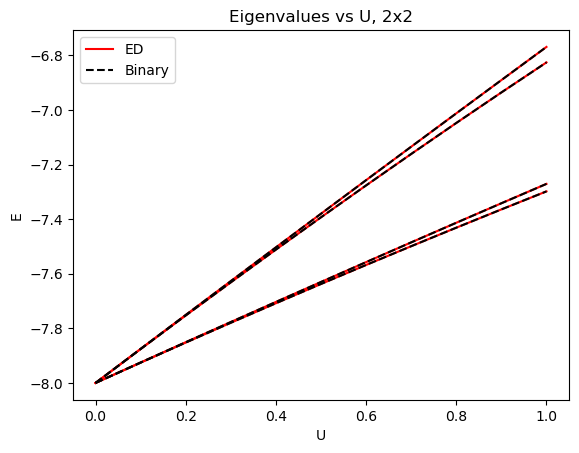

In [75]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [76]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-3.4874613241697716e-07
-8.656644068238961e-07
2.858709446940111e-08
-6.439306421412994e-07


## error $ = 10^{-8}$

In [77]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [78]:
U_sweep = jnp.linspace(0, U, 11)

In [79]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 22 iterations.
-7.925504903136572
Converged in 22 iterations.
-7.925196298608903
Converged in 23 iterations.
-7.875690465259199
Converged in 23 iterations.
-7.875194344072357
solve: 2
Converged in 22 iterations.
-7.852008006329681
Converged in 22 iterations.
-7.8507890808221035
Converged in 23 iterations.
-7.7527894343391255
Converged in 23 iterations.
-7.750773456805816
solve: 3
Converged in 22 iterations.
-7.779492164038153
Converged in 22 iterations.
-7.776784233010939
Converged in 23 iterations.
-7.631338529703544
Converged in 23 iterations.
-7.626731515845735
solve: 4
Converged in 22 iterations.
-7.707940517226001
Converged in 22 iterations.
-7.703187639129591
Converged in 23 iterations.
-7.511379485104534
Converged in 23 iterations.
-7.5030627159200804
solve: 5
Converged in 22 iterations.
-7.637336510340981
Converged in 22 iterations.
-7.63000518461436
Converged in 23 iterations.
-7.3929539107255415
Converged in 23 iterations.
-7.379761280803892
solve: 6
Con

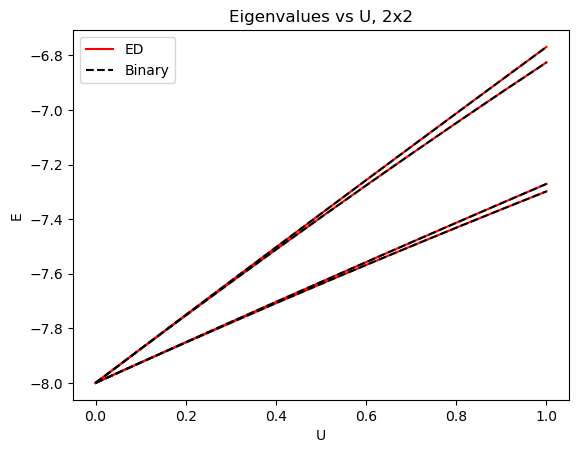

In [81]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [82]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

-6.544059516500056e-09
-8.60032667304722e-09
-1.0490251334260847e-08
-6.71556676934415e-09


## $\Delta U = 1$

## error $ = 10^{-3}$

In [83]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [84]:
U_sweep = jnp.linspace(0, U, 2)

In [85]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def binary_search_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx]

    xn = x0[subspace_eigvals_idx]
    fn = f(x0[subspace_eigvals_idx])

    # Iterative binary search
    for iteration in range(max_iter):
        # Update bounds based on fn's sign
        if fn < 0:
            upper_bound = xn
            lower_bound = fn + xn
        else:
            upper_bound = fn + xn
            lower_bound = xn

        # Update midpoint
        xn = (lower_bound + upper_bound) / 2

        # Update the function value at xn
        fn = f(xn)

        # Check for convergence
        if jnp.abs(fn) < E_cutoff:
            print(f"Converged in {iteration} iterations.")
            print(xn)
            return xn.item()

    print("Binary search did not converge within the maximum number of iterations.")
    print(xn)
    return xn.item()


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = binary_search_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 9 iterations.
-7.297615037584572
Converged in 9 iterations.
-7.271229845061133
Converged in 9 iterations.
-6.8259682035567515
Converged in 10 iterations.
-6.768858782555734


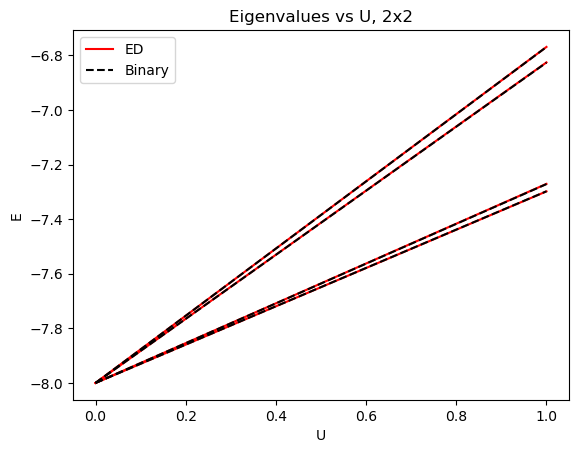

In [87]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Binary')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [88]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

0.000358405951383034
-0.0007194835273320876
-0.0007281884693073337
-0.00029391697346881074


# Wegstien's method
### ($\Delta U = 0.1$)

## error $ = 10^{-3}$

In [89]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [90]:
U_sweep = jnp.linspace(0, U, 11)

In [107]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.925504894268313
Converged in 2 iterations.
-7.925196289696059
Converged in 2 iterations.
-7.8756904578772415
Converged in 2 iterations.
-7.87519433663723
solve: 2
Converged in 2 iterations.
-7.852007997616005
Converged in 2 iterations.
-7.850789071970328
Converged in 2 iterations.
-7.752789427124377
Converged in 2 iterations.
-7.750773449404979
solve: 3
Converged in 2 iterations.
-7.779492155497808
Converged in 2 iterations.
-7.776784224230081
Converged in 2 iterations.
-7.631338522714131
Converged in 2 iterations.
-7.626731508486231
solve: 4
Converged in 2 iterations.
-7.707940508876066
Converged in 2 iterations.
-7.703187630429441
Converged in 6 iterations.
-7.511379478478642
Converged in 2 iterations.
-7.503062708608348
solve: 5
Converged in 2 iterations.
-7.637336502196304
Converged in 2 iterations.
-7.630005176005187
Converged in 27 iterations.
-7.3929539044269355
Converged in 2 iterations.
-7.379761273546145
solve: 6
Converged in 2 iteration

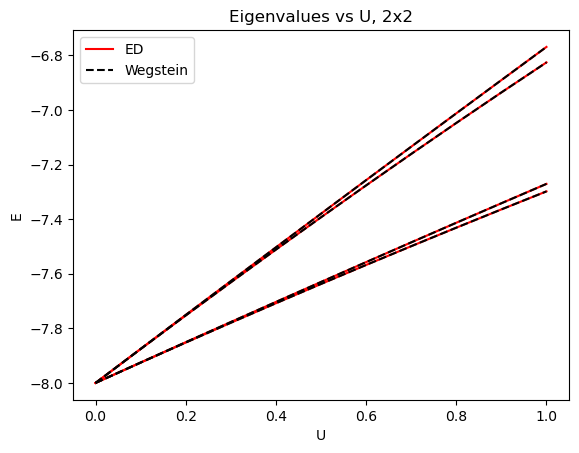

In [109]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [110]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

4.5339465515326083e-10
-5.91471760458262e-10
-1.931516280251344e-09
1.91455740150559e-10


## error $ = 10^{-6}$

In [111]:
kappa = 80
error = 6
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [112]:
U_sweep = jnp.linspace(0, U, 11)

In [113]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.925504891375123
Converged in 2 iterations.
-7.925196295100872
Converged in 2 iterations.
-7.87569045433809
Converged in 2 iterations.
-7.875194335597987
solve: 2
Converged in 2 iterations.
-7.852007958172921
Converged in 2 iterations.
-7.850789090826196
Converged in 2 iterations.
-7.752789393567677
Converged in 2 iterations.
-7.7507734310703515
solve: 3
Converged in 2 iterations.
-7.779492095010136
Converged in 2 iterations.
-7.776784236892709
Converged in 2 iterations.
-7.631338426442644
Converged in 2 iterations.
-7.626731457737048
solve: 4
Converged in 2 iterations.
-7.707940553719742
Converged in 2 iterations.
-7.703187589073207
Converged in 2 iterations.
-7.511379324171987
Converged in 2 iterations.
-7.503062649602356
solve: 5
Converged in 2 iterations.
-7.6373367434575625
Converged in 2 iterations.
-7.6300050526299295
Converged in 2 iterations.
-7.392953748519636
Converged in 2 iterations.
-7.379761277121056
solve: 6
Converged in 2 iteration

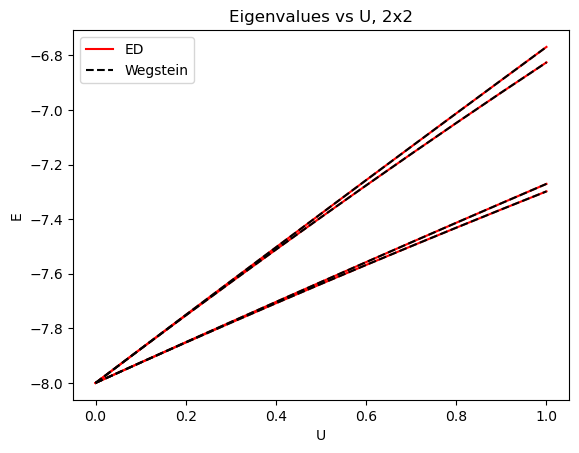

In [115]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [116]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

5.76984303002348e-07
-3.455803208041175e-07
6.355953896530764e-07
2.5260655078795935e-07


## error $ = 10^{-8}$

In [117]:
kappa = 80
error = 8
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [118]:
U_sweep = jnp.linspace(0, U, 11)

In [119]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.925504894268313
Converged in 2 iterations.
-7.925196289696059
Converged in 2 iterations.
-7.8756904578772415
Converged in 2 iterations.
-7.87519433663723
solve: 2
Converged in 2 iterations.
-7.852007997616005
Converged in 2 iterations.
-7.850789071970328
Converged in 2 iterations.
-7.752789427124377
Converged in 2 iterations.
-7.750773449404979
solve: 3
Converged in 2 iterations.
-7.779492155497808
Converged in 2 iterations.
-7.776784224230081
Converged in 2 iterations.
-7.631338522714131
Converged in 2 iterations.
-7.626731508486231
solve: 4
Converged in 2 iterations.
-7.707940508876066
Converged in 2 iterations.
-7.703187630429441
Converged in 6 iterations.
-7.511379478478642
Converged in 2 iterations.
-7.503062708608348
solve: 5
Converged in 2 iterations.
-7.637336502196304
Converged in 2 iterations.
-7.630005176005187
Converged in 27 iterations.
-7.3929539044269355
Converged in 2 iterations.
-7.379761273546145
solve: 6
Converged in 2 iteration

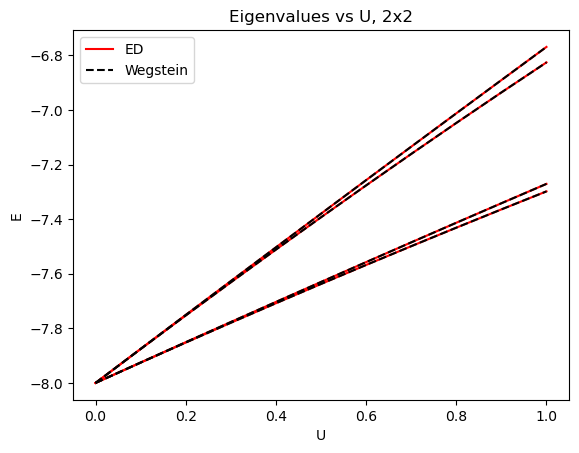

In [121]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [122]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

4.5339465515326083e-10
-5.91471760458262e-10
-1.931516280251344e-09
1.91455740150559e-10


## $\Delta U = 1$

## error $ = 10^{-3}$

In [123]:
kappa = 80
error = 3
file_name = f'coef_kappa{kappa}_error1e-{error}*'
file = glob.glob(file_name)
pcoefs = loadmat(file[0])
pcoefs = pcoefs['coef_full']

pcoefs = jnp.array([coef[0] for coef in pcoefs])
poly = Chebyshev(pcoefs)

In [124]:
U_sweep = jnp.linspace(0, U, 2)

In [125]:
solved_eigvals = [[vals.item() for vals in H0_eigvals_updated]]

def Wegstein_solver(Schur_complement, x0, subspace_eigvals_idx, E_cutoff=10**(-error), max_iter=100):

    def f(x):
        Schur = Schur_complement(x)
        sub_eigvals = jnp.linalg.eigvalsh(Schur)
        return sub_eigvals[subspace_eigvals_idx] + x
    
    # Initialize xn and fn
    xn = [x0[subspace_eigvals_idx], f(x0[subspace_eigvals_idx])]
    fn = [xn[1], f(xn[1])]    
    
    for i in range(1, max_iter):
        
        x_new = (xn[i-1]*fn[i] - xn[i]*fn[i-1]) / (xn[i-1] + fn[i] - xn[i] - fn[i-1])
        xn.append(x_new)
        fn.append(f(x_new))
        
        # If the energy difference is less than cutoff, the algorithm converge
        if abs(x_new - xn[i]) < E_cutoff:
            print(f"Converged in {i} iterations.")
            print(fn[-1])
            return fn[-1]
    
    print("Wegstein method did not converge within the maximum number of iterations.")
    print(fn[-1])   
    return fn[-1]


for i, UU in enumerate(U_sweep):
    # Skip the first iteration
    if i == 0:
        continue
    print('solve:', i)
    
    # Construct the Hamiltonian for the coulomb = U
    H = reduced_hubbard_model(U=float(UU), indices=reduced_H_indices)
    
    # Use binary search to solve the eigenvalues of different band
    solved_eigval = []
    for subspace_eigvals_idx in range(k):
        subspace_solved_eigval = Wegstein_solver(Schur_complement=lambda x: Schur_complement_qsp(H=H, E=x, init_eigvecs=H0_eigvecs_updated, degeneracy_idx=degeneracy_idx, dim=reduced_dim, poly=poly, kappa=kappa), 
                                                x0=solved_eigvals[-1], subspace_eigvals_idx=subspace_eigvals_idx)
        solved_eigval.append(subspace_solved_eigval)
    solved_eigvals.append(solved_eigval)
solved_eigvals = jnp.array(solved_eigvals).T

solve: 1
Converged in 2 iterations.
-7.296958746775182
Converged in 2 iterations.
-7.270544146482937
Converged in 2 iterations.
-6.825004767299083
Converged in 2 iterations.
-6.768275650668384


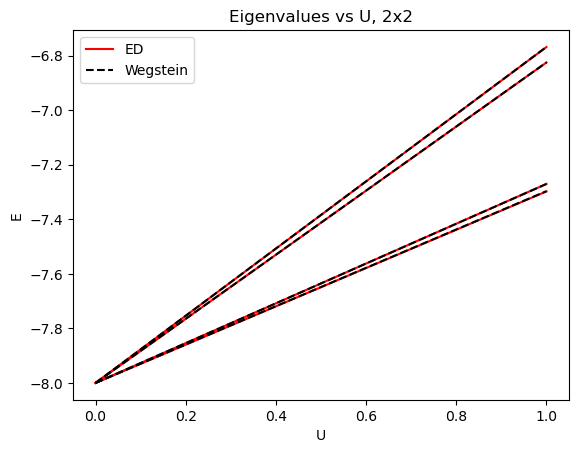

In [127]:
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep_ED, H_eigvals_sweep[band], 'red')
for band in range(degeneracy_idx[0], degeneracy_idx[1] + 1):
    plt.plot(U_sweep, solved_eigvals[band], 'black', linestyle='dashed')

plt.plot(U_sweep_ED[0], H_eigvals_sweep[band][0], 'red', label='ED')
plt.plot(U_sweep[0], solved_eigvals[0, 0], 'black', linestyle='dashed', label='Wegstein')

plt.xlabel('U')
plt.ylabel('E')
plt.title(f'Eigenvalues vs U, {x_dimension}x{y_dimension}')
# plt.ylim(jnp.min(solved_eigvals) - 0.5, jnp.max(solved_eigvals) + 0.5)

plt.legend()
plt.show()

In [128]:
print(solved_eigvals.T[-1, 0]-H_eigvals_sweep.T[-1, 0])
print(solved_eigvals.T[-1, 1]-H_eigvals_sweep.T[-1, 1])
print(solved_eigvals.T[-1, 2]-H_eigvals_sweep.T[-1, 2])
print(solved_eigvals.T[-1, 3]-H_eigvals_sweep.T[-1, 3])

0.0010146967607731483
-3.378494913608421e-05
0.00023524778836137017
0.0002892149138808975
